#### Libraries imports, downloads and constants

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

import pickle
import bcolz
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
config = {
    'batch_size': 256,       
    'lr': 0.005,           
    'epochs' : 10,     
    'data_path' : "./data/",  
    'max_length' : 300,
    'reuters_remove' : True
}

In [5]:
# Download NLTK resources (you only need to do this once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data preprocessing

In [6]:
# Function for text preprocessing (stop-word removal and lemmatization)
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenization (split the text into words)
    words = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    #Cause it is third most used word
    stop_words.add("u")
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization (reduce words to their base or root form using WordNet lemmatizer)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the words back into a string
    processed_text = ' '.join(words)
    
    return processed_text

# Apply text preprocessing to the 'text' column in your DataFrame
trueNews = pd.read_csv('data/True.csv')
trueNews['processed_text'] = trueNews['text'].apply(preprocess_text)
fakeNews = pd.read_csv('data/Fake.csv')  
fakeNews['processed_text'] = fakeNews['text'].apply(preprocess_text)


In [7]:
#Calculating length of processed text and adding labels
def length_of_proccessed(text):
    text = text.split(" ")
    return len(text)

fakeNews["truth"] = 0
trueNews["truth"] = 1

fakeNews["length"] = fakeNews["processed_text"].apply(length_of_proccessed)
trueNews["length"] = trueNews["processed_text"].apply(length_of_proccessed)
allNews = pd.concat([fakeNews, trueNews], ignore_index=True)

In [8]:
#Dropping unused columns and removing too short news
allNews =  allNews[(allNews["length"] > 20)]
allNews = allNews.reset_index()
allNews = allNews.drop(["date", "subject", "index"], axis = 1)

In [10]:
#Splitting dataset
train_data = allNews.sample(frac = 0.75)
test_data = allNews.drop(train_data.index)

train_data = train_data.reset_index().drop(["index"], axis = 1)
test_data = test_data.reset_index().drop(["index"], axis = 1)

train_data.to_csv( config["data_path"] + "train.csv", index = False)
test_data.to_csv(config["data_path"] + "test.csv", index = False)

#### Pytorch section - definition of NN, training and etc.

In [11]:
#using gpu if avaible otherwise cpu
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [12]:
#Creating required files for creating embeddings
#One time call, it is quite slow.
# https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'data/glove.twitter.27B.100.dat', mode='w')

with open('data/glove.twitter.27B.100d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float64)
        vectors.append(vect)
        #not embbedings for all words, cause there was some bug with loading last one
        #and the last ones were not english words
        if(idx == 1193500):
            break
            
vectors = bcolz.carray(vectors.reshape((1193500, 100)), rootdir=f'{config["data_path"]}glove.twitter.27B.100.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{config["data_path"]}27B.100_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{config["data_path"]}27B.100_words.pkl', 'wb'))

In [13]:
def create_embedings(vocabulary):
    
    vectors = bcolz.open(f'{config["data_path"]}glove.twitter.27B.100.dat')[:]
    words = pickle.load(open(f'{config["data_path"]}27B.100_words.pkl', 'rb'))
    word2idx = pickle.load(open(f'{config["data_path"]}27B.100_words.pkl', 'rb'))
    
    glove = {w: vectors[word2idx[w]] for w in words}
    word_to_idx = {}
    
    weights = []
    counter = 0
    for i in range(len(vocabulary)):
        if counter == 10000:
            break
        if vocabulary[i] in glove:
            #removing reutes from embeddings and so from the data
            if vocabulary[i] == "reuters" and config["reuters_remove"]:
                continue
            weights.append(glove[vocabulary[i]])
            word_to_idx[vocabulary[i]] = counter
            counter += 1
            
    weights.append([0 for i in range(100)]) # adding pad element
    weights = np.array(weights)
    weight = torch.FloatTensor(weights)
    embedding = nn.Embedding.from_pretrained(weight, padding_idx = 10000)
    return embedding, word_to_idx

In [14]:
#Calculating most frequent words
train_df = pd.read_csv(config["data_path"] + "train.csv") 
frequenct_words = train_df.processed_text.str.split(expand=True).stack().value_counts()
vocabulary = frequenct_words.index.tolist()

embedding, word_to_idx = create_embedings(vocabulary)

#### Dataset 

In [15]:
class NewsDataset(Dataset):
    def __init__(self, text_dir, word_to_idx):
        self.text_dir = text_dir
        self.df = pd.read_csv(self.text_dir)
        self.word_to_idx = word_to_idx
        self.size = len(self.df)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        counter = 0
        text_to_train = []
        for i in row.processed_text:
            if counter == config["max_length"]:
                break
            if i == "reuters" and config["reuters_remove"]:
                continue
            if i in self.word_to_idx:
                text_to_train.append(self.word_to_idx[i])
                counter += 1
        if counter < config["max_length"]:
            #padding
            text_to_train = text_to_train + [10000 for i in range(config["max_length"] - counter)]  
        return torch.tensor(text_to_train) , torch.tensor(row.truth).float()

In [16]:
#initialize datasets
#In the paper there was no validating dataset/split so we are using test for validation/ results and etc.
#We recognize that it is bad practice, in hindsight we should make validating split.
train_dataset = NewsDataset(config["data_path"] + "train.csv", word_to_idx)
test_dataset = NewsDataset(config["data_path"] + "test.csv", word_to_idx)

train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=config["batch_size"],  shuffle = False)

#### Neural network

In [17]:
class Classifier(nn.Module):
    def __init__(self, embedding):
        super(Classifier,self).__init__()
        self.embedings = embedding
        self.lstm1 = nn.LSTM(100,128, 1, batch_first=True)
        self.lstm2 =  nn.LSTM(128, 64,1, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        self._reinitialize()

    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization cause we believe they used tensorflow and not pytorch
        from https://www.kaggle.com/code/junkoda/pytorch-lstm-with-tensorflow-like-initialization#Model
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)

        
    def forward(self, x):
        #x.float()
        x = self.embedings(x)
        x, hidden = self.lstm1(x)
        x , hidden2 = self.lstm2(x)
        
        x = self.linear(hidden2[0])
        x = x.reshape( x.size()[1]) 
        return x.float()    

#### Neural network training

In [18]:
def fit(model,loss_criterion,optimizer,epochs,train_dataloader,valid_dataloader):
    training_loss, test_loss, training_accuracy, test_accuracy = [], [], [], []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        training_loss_epoch, training_accuracy_epoch = train(train_dataloader, model, loss_criterion, optimizer)
        test_loss_epoch, test_accuracy_epoch = test(valid_dataloader, model, loss_criterion)
        training_loss.append(training_loss_epoch)
        test_loss.append(test_loss_epoch)
        training_accuracy.append(training_accuracy_epoch)
        test_accuracy.append(test_accuracy_epoch)
        print(f"Test Error:  Avg loss: {test_loss_epoch:>8f} \n")
    print("Done!")
    return training_loss, test_loss, training_accuracy, test_accuracy

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batches = len(dataloader)
    model.train()
    test_loss, accuracy = 0, 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        #Predicting one batch
        X, y = X.to(dev), y.to(dev)
        pred = model(X)

        #calculating loss
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #statistics
        new_pred = [1 if x >= 0.5 else 0 for x in pred]
        accuracy += sum([ 1 if new_pred[i] == y[i] else 0 for i in range(len(new_pred))])
        test_loss += loss.item()
        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss of this batch: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    test_loss /= batches
    accuracy /= size
    return test_loss, accuracy

In [20]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(dev), y.to(dev)
            pred = model(X)
            #statistics
            test_loss += loss_fn(pred, y).item()
            new_pred = [1 if x >= 0.5 else 0 for x in pred]
            accuracy += sum([ 1 if new_pred[i] == y[i] else 0 for i in range(len(new_pred))])
    test_loss /= batches
    accuracy /= size
    return test_loss, accuracy

In [21]:
model = Classifier(embedding)
model = model.to(dev)
optimizer = torch.optim.Adam(model.parameters(),lr=config["lr"])
loss_criterion = torch.nn.BCELoss().to(dev)

training_loss, test_loss, training_accuracy, test_accuracy = fit(model,loss_criterion,optimizer,config["epochs"],train_dataloader,test_dataloader)

  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

Epoch 1
-------------------------------


  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

Test Error:  Avg loss: 0.670568 

Epoch 2
-------------------------------


  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

Test Error:  Avg loss: 0.671012 

Epoch 3
-------------------------------


  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

Test Error:  Avg loss: 0.623859 

Epoch 4
-------------------------------


  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

Test Error:  Avg loss: 0.132156 

Epoch 5
-------------------------------


  1%|▋                                                                                 | 1/127 [00:00<00:25,  4.90it/s]

Test Error:  Avg loss: 0.021997 

Epoch 6
-------------------------------


  1%|▋                                                                                 | 1/127 [00:00<00:24,  5.17it/s]

Test Error:  Avg loss: 0.021139 

Epoch 7
-------------------------------


  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

Test Error:  Avg loss: 0.018971 

Epoch 8
-------------------------------


  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

Test Error:  Avg loss: 0.016107 

Epoch 9
-------------------------------


  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

Test Error:  Avg loss: 0.016618 

Epoch 10
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:05<00:00,  8.12it/s]

Test Error:  Avg loss: 0.014654 

Done!


#### Procedure for creating graphs

In [ ]:
#procedure for creating data for graphs
trai_l, test_l, trai_ac, test_ac = [], [], [], []
for i in range(10):
    model = Classifier(embedding)
    model = model.to(dev)
    optimizer = torch.optim.Adam(model.parameters(),lr=config["lr"])
    loss_criterion = torch.nn.BCELoss().to(dev)
    training_loss, test_loss, training_accuracy, test_accuracy = fit(model,loss_criterion,optimizer,config["epochs"],train_dataloader,test_dataloader)
    trai_l.append(training_loss)
    test_l.append(test_loss)
    trai_ac.append(training_accuracy) 
    test_ac.append(test_accuracy)

results = {"trai_l": trai_l, "test_l":test_l, "trai_ac":trai_ac, "test_ac": test_ac}
df = pd.DataFrame(results)
df.to_csv(f'{config["data_path"]}results-no-reuters-005.txt')

In [22]:
no_reuters_005 = pd.read_csv(f'{config["data_path"]}results-no-reuters-005.txt')
dataframes = [no_reuters_005 ]

In [23]:
def string_to_list(array):
    return [ float(i) for i in array[1:-2].replace(",","").split() ]


#preparing data
for df in dataframes:
    df.drop("Unnamed: 0" , axis = 1, inplace= True)
    for (columnName, columnData) in df.items():
        df[columnName] = df[columnName].apply(string_to_list)

In [24]:
def create_plot(series, title, y ="Accuracy on test split"): #, title, y
    result_dict = {}
    counter = 1
    for i in series:
        result_dict["run " + str(counter)] = i
        counter += 1
    clean_data = pd.DataFrame(result_dict)
    clean_data.plot.line(figsize = (10,10), xlabel= "Epoch", ylabel = y, legend = False, title = title) # , title= title

In [27]:
variable = "test_ac"
#variable = "test_l"

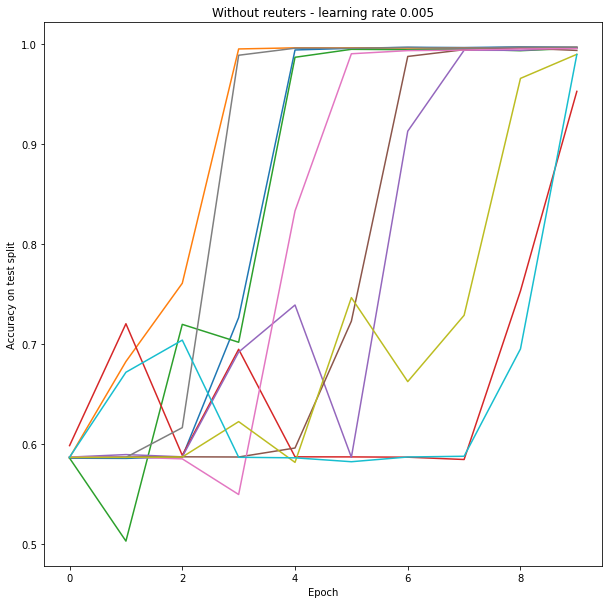

In [28]:
create_plot(no_reuters_005[variable], "Without reuters - learning rate 0.005")
